# Clustering

In this notebook, we build upon the results from PCA to perform clustering.

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import time
from typing import Callable

# from bokeh.models import LinearColorMapper, BasicTicker, ColorBar, LabelSet
# from bokeh.plotting import figure, show, ColumnDataSource, save, output_file
import bokeh.io as bio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.cluster as cluster

In [3]:
bio.output_notebook()

Loading BokehJS ...

Let's review the data after PCA transformation.

In [26]:
usarrests_path = Path("usarrests_pca.csv")

usarrests_converters = {
    "State": str,
    "Murder": np.float32,
    "Assault": np.float32,
    "UrbanPop": np.float32,
    "Rape": np.float32
}

usarrests_df = pd.read_csv(
    usarrests_path,
    header=0,
    converters=usarrests_converters
)

usarrests_data_df = usarrests_df.iloc[:, 1:]

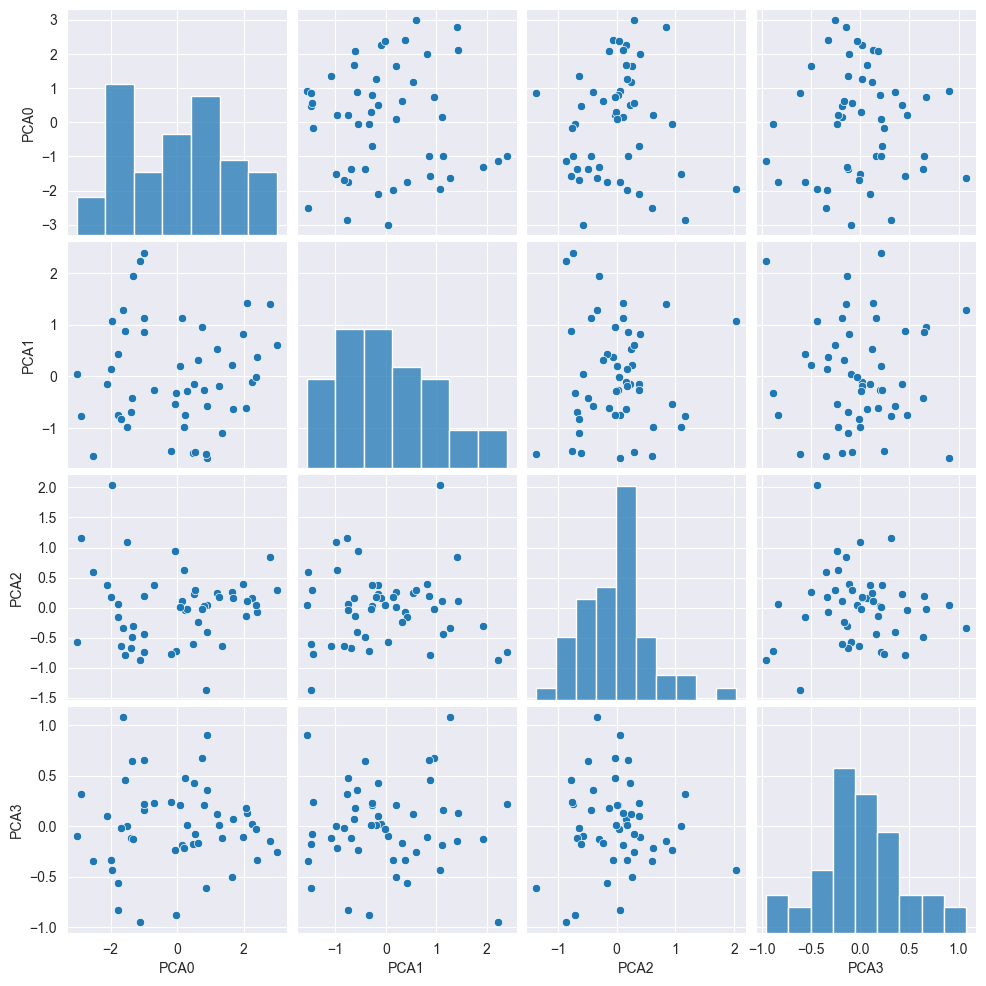

In [5]:
sns.pairplot(usarrests_data_df)

Let's try using the scikit-learn methods for clustering. For this, let's analyze the first two components.


In [ ]:
cluster_data = usarrests_df[["PCA0", "PCA1"]]

What does `cluster.KMeans` do?

## K-Means Clustering

This is not a "smart" or clever algorithm, but is intuitive. The algorithm attempts to minimize the quantity $\mathcal{F}$ given $M$ target clusters.

$$
\begin{align}
    \mathcal{F} & =\underset{C_{1},C_{2},...,C_{M}}{\text{minimize}}\left\{ \sum_{m=1}^{M}W\left(C_{m}\right)\right\},
\end{align}
$$

where $C_m$ is a cluster and $W$ is the weight function. The form of $W$ is

$$
\begin{aligned}
    W\left(C_{m}\right) & =\frac{1}{\left|C_{m}\right|}\sum_{i,i^{\prime}\in C_{m}}\sum_{j=1}^{P}\left(x_{ij}-x_{i^{\prime}j}\right)^{q},
\end{aligned}
$$

where $\left|C_{m}\right|$ is the cardinality/length of the cluster and $q$ is usually 2 indicating the euclidean distance metric.

In [49]:
algo = cluster.KMeans()
algo

KMeans()

Like the name implies, the function `cluster.KMeans` is the constructor for a class. To fit data, we run `fit_predict`.

In [51]:
labels = algo.fit_predict(cluster_data.to_numpy())

/Users/mhogan/Documents/unsuperlearn/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Looks like we need to specify constructor arguments like `n_init`. What does the result look like?

In [52]:
labels

array([1, 1, 3, 7, 3, 3, 0, 2, 3, 1, 0, 5, 3, 2, 5, 2, 7, 1, 5, 1, 0, 3,
       5, 6, 2, 7, 5, 3, 5, 0, 3, 3, 6, 4, 2, 2, 2, 2, 0, 6, 4, 1, 3, 0,
       4, 2, 0, 4, 5, 7], dtype=int32)

In [28]:
cluster_data.shape, labels.shape

((50, 2), (50,))

The `labels` are a vector of enumerated integer cluster indices. What does that look like in general? Let's make a method to plot these.

In [44]:
sns.set_context('poster')
sns.set_color_codes()

def plot_clusters(data_df, algorithm, args, kwds):
    """Plot cluster results using a specified algorithm

    Parameters
    ----------
    data_df : pd.DataFrame
        Data with two columns
    algorithm : Callable
        Clustering algorithm constructor
    args : tuple
        Arguments for algorithm
    kwds : dict
        Keyword arguments for algorithm

    Returns
    -------
    None
    """
    start_time = time.time()
    data = data_df.to_numpy()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.max(np.unique(labels)) + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame: plt.Figure = plt.gca()
    x_axis = frame.axes.get_xaxis()
    y_axis = frame.axes.get_yaxis()
    x_axis.set_label_text(data_df.columns[0])
    y_axis.set_label_text(data_df.columns[1])
    x_min, x_max = np.min(data[:, 0]) - 1, 1 + np.max(data[:, 0])
    y_min, y_max = np.min(data[:, 1]) - 1, 1 + np.max(data[:, 1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(
        x_min,
        y_min,
        'Clustering took {:.2f} s'.format(end_time - start_time),
        fontsize=14
    )
    plt.show(frame)


Let's try finding two clusters first. As I mentioned in the previous notebook, I think there is a cluster split about "PCA0"$\approx0$

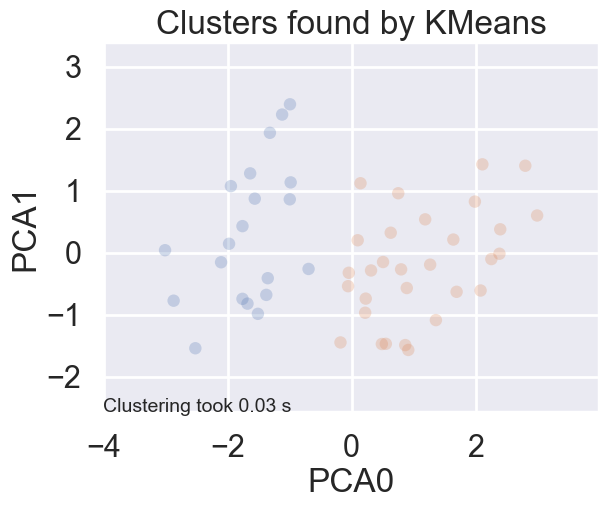

In [46]:
plot_clusters(cluster_data, cluster.KMeans, (), {'n_clusters': 2, "n_init": "auto"})

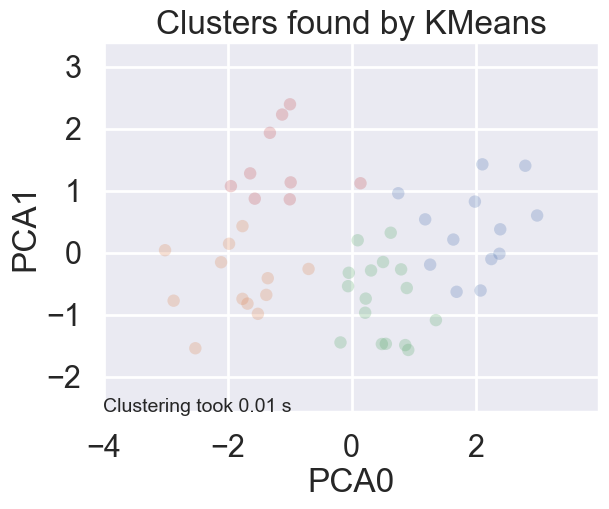

In [47]:
plot_clusters(cluster_data, cluster.KMeans, (), {'n_clusters': 4, "n_init": "auto"})

That is what I expected! What about 4 clusters?